# Classer avec la méthode des k-Plus Proches Voisins

Dans ce TP nous allons implémenter notre première Intelligence Artificielle à partir de la méthode des k-Plus Proches Voisins étudiée en TD. Nous allons implémenter, tester, évaluer et étudier cette méthode de classification sur un jeu de données réelles.

## A. Charger, explorer puis préparer le tableau de données

Commencez par importer dans un Dataframe `zoo` les données du fichier `zoo.csv`.

In [2]:
import pandas as pd
import numpy as np
zoo = pd.read_csv('donnees/zoo.csv')
print(zoo)

        Name  hair  feathers  eggs  milk  airbone  aquatic  predator  toothed  \
0   aardvark     1         0     0     1        0        0         1        1   
1   antelope     1         0     0     1        0        0         0        1   
2       bass     0         0     1     0        0        1         1        1   
3       bear     1         0     0     1        0        0         1        1   
4       boar     1         0     0     1        0        0         1        1   
..       ...   ...       ...   ...   ...      ...      ...       ...      ...   
95   wallaby     1         0     0     1        0        0         0        1   
96      wasp     1         0     1     0        1        0         0        0   
97      wolf     1         0     0     1        0        0         1        1   
98      worm     0         0     1     0        0        0         0        0   
99      wren     0         1     1     0        1        0         0        0   

    backbone  breathes  ven

Explorez le dataset `zoo`: Combien d'individus? Combien de descripteurs? Quelle est la nature (type) des descripteurs? Y-a-t'il des valeurs manquantes?

In [3]:
print(zoo.shape)
print(zoo.dtypes)
zoo.describe()

(100, 18)
Name         object
hair          int64
feathers      int64
eggs          int64
milk          int64
airbone       int64
aquatic       int64
predator      int64
toothed       int64
backbone      int64
breathes      int64
venomous      int64
fins          int64
legs          int64
tail          int64
domestic      int64
size        float64
type          int64
dtype: object


,hair,feathers,eggs,milk,airbone,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,size,type
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.43000,0.200000,0.580000,0.410000,0.240000,0.350000,0.55,0.600000,0.820000,0.79000,0.070000,0.170000,2.830000,0.750000,0.130000,91.728500,2.810000
std,0.49757,0.402015,0.496045,0.494311,0.429235,0.479372,0.50,0.492366,0.386123,0.40936,0.256432,0.377525,2.040276,0.435194,0.337998,105.726317,2.101923
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,1.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,1.00000,0.000000,0.000000,2.000000,0.750000,0.000000,17.875000,1.000000
50%,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00,1.000000,1.000000,1.00000,0.000000,0.000000,3.000000,1.000000,0.000000,55.000000,2.000000
75%,1.00000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,1.000000,1.00000,0.000000,0.000000,4.000000,1.000000,0.000000,127.500000,4.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.00000,1.000000,1.000000,8.000000,1.000000,1.000000,600.000000,7.000000


Dans ce dataset, la dernière colonne `type` correspond à la catégorie de l'animal :
|  Type  |    Catégorie    |
| :---------:|---------|
| 1 |Mammifères|
| 2 |Oiseaux|
| 3 |Reptiles|
| 4 |Poissons|
| 5 |Amphibiens|
| 6 |Insectes|
| 7 |Invertébrés|

Notre IA devra prédire la catégorie d'un animal à partir de sa description (sans le `Name`). Il s'agit donc d'une tâche de prédiction à **7 classes**.

Observez la distribution des individus selon la variable de classe (`type`) et constatez le déséquilibre des classes. Cela aura-t'il une incidence sur la méthode de k-PPV?

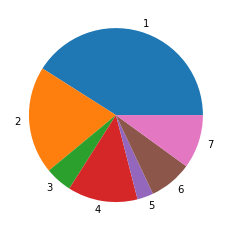

In [4]:
import matplotlib.pyplot as plt
labels, sizes = np.unique(zoo['type'], return_counts=True)
plt.pie(sizes, labels=labels)
plt.show()

A partir du dataframe `zoo`, vous allez construire deux tableaux Numpy :
- `X` est la matrice (100x16) des descriptions des individus
- `y` est le vecteur contenant les (100) catégories d'animaux 

In [5]:
X = np.array(zoo.iloc[:, 1:-1])
y = np.array(zoo["type"])

Nous allons à présent découper `X` et `y` en deux sous-ensembles :
- `X_train` : qui contient des individus que la méthode k-PPV utilisera pour prédire
- `X_test`  : qui contient des individus que nous utiliserons pour évaluer notre IA (et ainsi ajuster le paramètre k)
- `y_train` : qui contient les labels des individus de `X_train`
- `y_test`  : qui contient les labels des individus de `X_test`

Ecrire une fonction (générique) `train_test_split(X, y, train_ratio)` qui réalise un tel découpage :

In [6]:
import random

def train_test_split(X, y, train_ratio):
    """découpe un dataset X en deux ensembles d'entraînement (train) et de test ainsi que les labels associés

    Args:
        X (matrice Numpy): le dataset à découper
        y (vecteur Numpy): le vecteur des labels à découper
        train_ratio (float): entre 0.0 et 1.0 = proportion du dataset à inclure dans l'ensemble d'entraînement (train)

    Returns:
        X_train (matrice Numpy): le sous-ensemble d'entraînement
        X_test (matrice Numpy):  le sous-ensemble de test
        y_train (vecteur Numpy): les labels données d'entraînement
        y_test (vecteur Numpy):  les labels données de test

    """
    N = X.shape[0]
    if N != y.shape[0]:
        return None
    
    ids = np.arange(N)
    np.random.shuffle(ids)
    nb_train = int(N * train_ratio)
    train_ids, test_ids = ids[:nb_train], ids[nb_train:]
    return X[train_ids, :], X[test_ids, :], y[train_ids], y[test_ids]

X_train, X_test, y_train, y_test = train_test_split(X, y, 0.7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 16)
(30, 16)
(70,)
(30,)


Utilisez votre fonction pour découper notre dataset `X` en deux sous-ensembles de mêmes tailles.

Vérifiez que les déséquilibres des classes sont globalement respectés (relancez le découpage si certaines classes sont absentes dans l'un des deux sous-ensembles).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.5)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([1, 2, 3, 4, 5, 6, 7], dtype=int64), array([23, 11,  3,  6,  1,  1,  5], dtype=int64))
(array([1, 2, 3, 4, 5, 6, 7], dtype=int64), array([18,  9,  2,  7,  2,  7,  5], dtype=int64))


---

## B. Implémenter et évaluer la méthode k-PPV (non-pondérée)

Définissez une fonction `predict_kNN(k, X, y, x_new)` qui prédit la classe d'une description `x_new` par la méthodes k-PPV non-pondérée utilisée sur les données `X` de ayant pour labels `y` avec la distance Euclidienne.

In [8]:
def predict_kNN(k, X, y, x_new):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer

    Returns:
        y_new (label):  le label prédit

    """
    distances = np.linalg.norm(X - x_new, axis=1)
    nearest_neighbor_ids = distances.argsort()[:k]
    nearest_neighbor_class = y[nearest_neighbor_ids]
    labels, counts = np.unique(nearest_neighbor_class, return_counts=True)
    return labels[counts.argsort()[-1]]

Utilisez la fonction `predict_kNN` pour prédire la classe de l'individu situé à l'indice 23 dans `X_test` à partir des données d'entraînement (`X_train`, `y_train`). Affichez la classe prédite selon différentes valeurs de `k` et comparez avec la vraie classe de l'individu (`y_test[23]`). 

In [9]:
i = 46
print([predict_kNN(k, X_train, y_train, X_test[i,:]) for k in range(1, 20)])
y_test[i]

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


1

Définissez une fonction `error_kNN(k, X_train, y_train, X_test, y_test)` qui renvoie le taux d'erreur de prédiction de la méthode k-PPV sur des données de test. 

In [10]:
def error_kNN(k, X_train, y_train, X_test, y_test,):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    y_pred = np.array([predict_kNN(k, X_train, y_train, x) for x in X_test])
    return 1 - np.mean(y_pred == y_test)

Tracez la courbe du taux d'erreur en fonction du paramètre `k`. Quelle valeur choisirez-vous pour `k`? Est-ce que votre classifieur vous semble performant?

[0.48, 0.6, 0.62, 0.48, 0.6799999999999999, 0.62, 0.5800000000000001, 0.6, 0.5800000000000001, 0.64, 0.62, 0.62, 0.64, 0.64, 0.64, 0.64, 0.62, 0.64, 0.64, 0.62, 0.62, 0.62, 0.62, 0.6, 0.62, 0.6599999999999999, 0.6599999999999999, 0.6799999999999999, 0.6599999999999999]


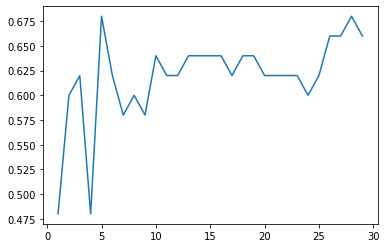

In [11]:
print([error_kNN(k, X_train, y_train, X_test, y_test) for k in range(1, 30)])
plt.plot(range(1, 30), [error_kNN(k, X_train, y_train, X_test, y_test) for k in range(1, 30)])

Avant de conclure (trop vite!)... quel serait le taux d'erreur d'un classifieur k-PPV qui fonderait ses prédictions sur la taille des animaux uniquement (descripteur `size`)?

[0.54, 0.4800000000000001, 0.6900000000000001, 0.5900000000000001, 0.5599999999999999, 0.6199999999999999, 0.5800000000000001, 0.59, 0.6, 0.45999999999999996, 0.54, 0.57, 0.5299999999999999, 0.55, 0.5700000000000001, 0.5200000000000001, 0.52, 0.61, 0.62, 0.55, 0.58, 0.61, 0.5599999999999999, 0.6300000000000001, 0.57, 0.68, 0.62, 0.5599999999999999, 0.6900000000000001]


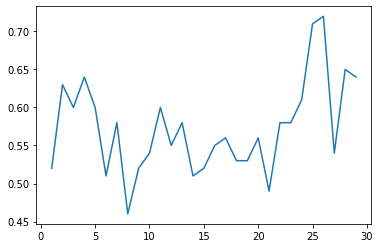

In [12]:

def cross_validation_error(k, X, y, n_folds=5):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données
        y (vecteur Numpy): le vecteur des labels des données
        n_folds (int): nombre de folds à utiliser pour la validation croisée

    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    N = X.shape[0]
    fold_size = N // n_folds
    errors = []
    for fold in range(n_folds):
        ids = np.arange(N)
        np.random.shuffle(ids)
        train_ids = np.concatenate([ids[:fold*fold_size], ids[(fold+1)*fold_size:]])
        test_ids = ids[fold*fold_size:(fold+1)*fold_size]
        error = error_kNN(k, X[train_ids], y[train_ids], X[test_ids], y[test_ids])
        errors.append(error)
    return np.mean(errors)

print([cross_validation_error(k, X, y) for k in range(1, 30)])
plt.plot(range(1, 30), [cross_validation_error(k, X, y) for k in range(1, 30)])

## C. Normaliser les données

Vous avez constaté que tous les descriteurs n'ont pas la même influence dans le calcul des distances entre individus, du fait de l'amplitude des valeurs associée à chaque descripteurs.

Pour faire en sorte que chaque descripteur ait la même influence dans le traitement du tableau de données, on procède à une **normalisation** des données. 

> Normaliser un ensemble $Z$ consiste à ramener toutes ses valeurs dans l'intervalle $[0,1]$ par l'opération : $$\tilde{z}_{i}=\frac{z_{i}-min_Z}{max_Z-min_Z}$$
>

Complétez la classe `Normalizer` ci-dessous qui définit un **outil** de normalisation d'un jeu de données. La normalisation d'un jeu de données procédera en deux temps :
- calcul des paramètres de la fonction de normalisation sur des données (méthode `.fit()`)
- application de la fonction de normalisation sur des données (méthode `.transform()`)

In [13]:
class Normalizer:
    
    min = None
    max = None
    
    def fit(self, X):
        """calcule les min et max de chaque colonne de X"""
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)
    
    def transform(self, X):
        """renvoie X normalisé"""
        return (X - self.min) / (self.max - self.min)
        

Appliquez la normalisation sur l'ensemble des individus (100 descriptions) puis comparez l'erreur faite par la méthode des k-PPV avant et après normalisation. Concluez sur l'utilité de cette étape de normalisation.

In [14]:
normalizer = Normalizer()
normalizer.fit(X_train)
X_train_normalized = normalizer.transform(X_train)
X_test_normalized = normalizer.transform(X_test)

print(X_train_normalized)
print(X_test_normalized)

[[0.         0.         1.         0.         0.         0.
  1.         1.         1.         1.         1.         0.
  0.         1.         0.         0.52594153]
 [0.         0.         1.         0.         0.         0.
  1.         1.         1.         1.         0.         0.
  0.5        1.         0.         0.19673426]
 [0.         0.         1.         0.         0.         1.
  0.         1.         1.         0.         0.         1.
  0.         1.         0.         0.04134843]
 [0.         1.         1.         0.         1.         1.
  1.         0.         1.         1.         0.         0.
  0.25       1.         0.         0.14669476]
 [0.         1.         1.         0.         1.         0.
  0.         0.         1.         1.         0.         0.
  0.25       1.         0.         0.03871477]
 [1.         0.         0.         1.         0.         0.
  0.         1.         1.         1.         0.         0.
  0.5        1.         1.         0.05451672

## D. Implémenter et évaluer la méthode k-PPV pondérée

Implémentez la variante pondérée de la méthode k-PPV dans une version généralisée de la fonction `predict_kNN(k, X, y, x_new, weights)`

In [15]:
def predict_kNN(k, X, y, x_new, weights='uniform'):
    """implémente le classifieur du k-Plus Proches Voisins 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données d'entraînement
        y (vecteur Numpy): le vecteur des labels des données d'entraînement
        x_new (vecteur Numpy) : le vecteur de description d'une nouvelle donnée à classer
        weights ('uniform', 'distance') : méthode de pondération utilisée pour la prédiction

    Returns:
        y_new (label):  le label prédit

    """
    distances = np.linalg.norm(X - x_new, axis=1)
    nearest_neighbor_ids = distances.argsort()[:k]
    nearest_neighbor_class = y[nearest_neighbor_ids]
    if weights == 'uniform':
        labels, counts = np.unique(nearest_neighbor_class, return_counts=True)
        return labels[counts.argsort()[-1]]
    elif weights == 'distance':
        return nearest_neighbor_class[np.argmin(distances[nearest_neighbor_ids])]
    
print([predict_kNN(k, X_train_normalized, y_train, X_test_normalized[i,:], weights='distance') for k in range(1, 20)])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Généralisez également la fonction d'évaluation `error_kNN(k, X_train, y_train, X_test, y_test, weights)` avec l'argument supplémentaire `weights`

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


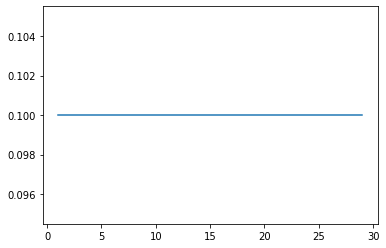

In [17]:
def error_kNN(k, X_train, y_train, X_test, y_test, weights='uniform'):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X_train (matrice Numpy): le dataset des données d'entraînement
        y_train (vecteur Numpy): le vecteur des labels des données d'entraînement
        X_test (vecteur Numpy) : le dataset des données de test
        y_test (vecteur Numpy): le vecteur des labels des données de test
        weights ('uniform', 'distance') : méthode de pondération utilisée dans k-PPV


    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    y_pred = np.array([predict_kNN(k, X_train, y_train, x, weights) for x in X_test])
    return 1 - np.mean(y_pred == y_test)

print([error_kNN(k, X_train_normalized, y_train, X_test_normalized, y_test, weights='distance') for k in range(1, 30)])
plt.plot(range(1, 30), [error_kNN(k, X_train_normalized, y_train, X_test_normalized, y_test, weights='distance') for k in range(1, 30)])

Enfin, comparez l'erreur faite par chacune des deux versions de la méthode k-PPV (pondérée ou non).

[0.43000000000000005, 0.45, 0.4600000000000001, 0.36, 0.52, 0.48, 0.39, 0.42000000000000004, 0.51, 0.45, 0.43999999999999995, 0.41000000000000003, 0.5, 0.47000000000000003, 0.5199999999999999, 0.4600000000000001, 0.43999999999999995, 0.49000000000000005, 0.45, 0.44000000000000006, 0.4600000000000001, 0.47000000000000003, 0.4800000000000001, 0.49000000000000005, 0.44000000000000006, 0.45999999999999996, 0.44000000000000006, 0.4, 0.47000000000000003]


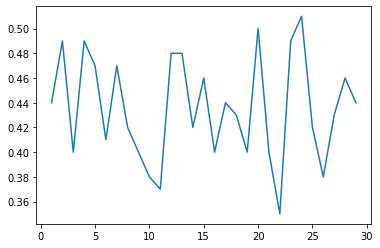

In [18]:

def cross_validation_error(k, X, y, n_folds=5, weights='uniform'):
    """calcule le taux d'erreur de prédiction par k-PPV sur les données de test 

    Args:
        k (int): nombre de voisins à utiliser pour prédire
        X (matrice Numpy): le dataset des données
        y (vecteur Numpy): le vecteur des labels des données
        n_folds (int): nombre de folds à utiliser pour la validation croisée
        weights ('uniform', 'distance') : méthode de pondération utilisée dans k-PPV

    Returns:
        error_rate (float):  le taux d'erreur de prédiciton (Nb. mauvaises prédictions / Nb. prédictions)

    """
    N = X.shape[0]
    fold_size = N // n_folds
    errors = []
    for fold in range(n_folds):
        ids = np.arange(N)
        np.random.shuffle(ids)
        train_ids = np.concatenate([ids[:fold*fold_size], ids[(fold+1)*fold_size:]])
        test_ids = ids[fold*fold_size:(fold+1)*fold_size]
        error = error_kNN(k, X[train_ids], y[train_ids], X[test_ids], y[test_ids], weights)
        errors.append(error)
    return np.mean(errors)

print([cross_validation_error(k, X, y, weights='distance') for k in range(1, 30)])
plt.plot(range(1, 30), [cross_validation_error(k, X, y, weights='distance') for k in range(1, 30)])